In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import skorch
import torch
from skorch import NeuralNetClassifier
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from scipy.stats import entropy
import random
import h5py
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import FeatureAgglomeration

In [9]:
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.utils import get_statistics
from torch.utils.data import DataLoader, Dataset

In [10]:
from scifAI.dl.models import PretrainedModel
from skorch.callbacks import LRScheduler,Checkpoint,EpochScoring,EarlyStopping
import torch.optim as optim
from skorch.helper import predefined_split

In [11]:


# Compare Algorithms
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.semi_supervised import LabelPropagation
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

In [12]:
from sklearn.random_projection import GaussianRandomProjection

In [13]:
from sklearn.metrics import plot_confusion_matrix, matthews_corrcoef, classification_report,confusion_matrix, accuracy_score, balanced_accuracy_score, cohen_kappa_score, f1_score,  precision_score, recall_score
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay


def classification_complete_report(y_true, y_pred ,labels = None  ): 
    print(classification_report(y_true, y_pred, labels = labels))
    print(15*"----")
    print("matthews correlation coeff: %.4f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.4f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.4f & balanced Accuracy: %.4f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.4f & micro F1 score: %.4f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.4f & micro Precision score: %.4f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.4f & micro Recall score: %.4f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    cm = confusion_matrix(y_true, y_pred,labels= labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    print(15*"----")

In [14]:
metadata = pd.read_csv("/home/jedrzej/projects/image_flow_cytometry_fine_tune/data/jedrzej/metadata_subset.csv.gz")
metadata

/var/tmp/ipykernel_1983349/2821946925.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv("/home/jedrzej/projects/image_flow_cytometry_fine_tune/data/jedrzej/metadata_subset.csv.gz")


,file,experiment,donor,condition,object_number,set,label
0,/home/jedrzej/projects/image_flow_cytometry_fi...,Experiment_1,Donor_1,+SEA,53764,unlabeled,-1
1,/home/jedrzej/projects/image_flow_cytometry_fi...,Experiment_1,Donor_1,+SEA,38075,unlabeled,-1
2,/home/jedrzej/projects/image_flow_cytometry_fi...,Experiment_1,Donor_1,+SEA,39302,unlabeled,-1
3,/home/jedrzej/projects/image_flow_cytometry_fi...,Experiment_1,Donor_1,+SEA,50406,unlabeled,-1
4,/home/jedrzej/projects/image_flow_cytometry_fi...,Experiment_1,Donor_1,+SEA,29629,train,No_cell_cell_interaction
...,...,...,...,...,...,...,...
1065905,/home/jedrzej/projects/image_flow_cytometry_fi...,Experiment_4,Donor_9,DIG-TCB,76910,unlabeled,-1
1065906,/home/jedrzej/projects/image_flow_cytometry_fi...,Experiment_4,Donor_9,DIG-TCB,89427,unlabeled,-1
1065907,/home/jedrzej/projects/image_flow_cytometry_fi...,Experiment_4,Donor_9,DIG-TCB,80928,unlabeled,-1
1065908,/home/jedrzej/projects/image_flow_cytometry_fi...,Experiment_4,Donor_9,DIG-TCB,83923,unlabeled,-1


In [15]:
metadata.set.unique()

array(['unlabeled', 'train', 'test', 'labeled', 'validation'],
      dtype=object)

In [16]:
indx = metadata.condition.isin(["-SEA","+SEA"])
metadata = metadata.loc[indx, :].reset_index(drop = True )

In [17]:
set_of_interesting_classes = ['B_cell',  'T_cell', 
                        'T_cell_with_signaling',
                        'T_cell_with_B_cell_fragments',
                        'B_T_cell_in_one_layer',
                        'Synapses_without_signaling', 
                        'Synapses_with_signaling',
                        'No_cell_cell_interaction', 
                        'Multiplets'] 

indx = metadata.set.isin([ "train", "validation","test" ])
indx = indx & metadata.label.isin(set_of_interesting_classes)

train_index = metadata["set"] == "train"
train_index = train_index & metadata.label.isin(set_of_interesting_classes)
train_index = train_index[train_index].index

validation_index = metadata["set"] == "validation"
validation_index = validation_index & metadata.label.isin(set_of_interesting_classes)
validation_index = validation_index[validation_index].index

test_index = metadata["set"] == "test"
test_index = test_index & metadata.label.isin(set_of_interesting_classes)
test_index = test_index[test_index].index

In [18]:
metadata["set"].unique()

array(['unlabeled', 'train', 'test', 'labeled', 'validation'],
      dtype=object)

In [19]:


label_map = dict()
for i, cl in enumerate(set_of_interesting_classes):
    label_map[cl] = i

label_map['-1'] = -1
label_map[-1] = -1


In [20]:
label_map

{'B_cell': 0,
 'T_cell': 1,
 'T_cell_with_signaling': 2,
 'T_cell_with_B_cell_fragments': 3,
 'B_T_cell_in_one_layer': 4,
 'Synapses_without_signaling': 5,
 'Synapses_with_signaling': 6,
 'No_cell_cell_interaction': 7,
 'Multiplets': 8,
 '-1': -1,
 -1: -1}

In [21]:
channels = {
     "Ch1": ("Greys", "BF"),  
     "Ch2": ("Greens", "Antibody"),
     "Ch3": ("Reds", "CD18"),
     "Ch4": ("Oranges", "F-Actin"),
     "Ch6": ("RdPu", "MHCII"),
     "Ch7": ("Purples", "CD3/CD4"),
     "Ch11": ("Blues", "P-CD3zeta"),
     "Ch12": ("Greens", "Live-Dead")
 }

In [22]:
import os

seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

np.random.seed(seed_value)
torch.manual_seed(seed_value)

In [23]:
selected_channels = [0,3,4,5,6]
model_dir = "models"
log_dir = "logs"
scaling_factor = 4095.
reshape_size = 256
train_transform = [
         transforms.RandomVerticalFlip(),
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(45)
        ]
test_transform = [ ]

In [24]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose(train_transform))

In [25]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=6)


/home/jedrzej/projects/image_flow_cytometry_fine_tune/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


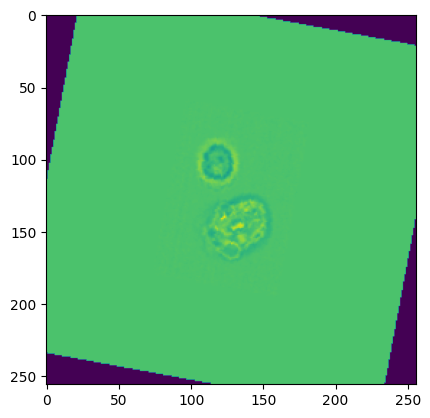

In [26]:
plt.imshow(train_dataset[0][0][0])


In [27]:
statistics = get_statistics(train_loader, selected_channels=selected_channels)


100%|██████████| 23/23 [06:29<00:00, 16.94s/it]

statistics used: {'min': tensor([0., 0., 0., 0., 0.]), 'p01': tensor([0., 0., 0., 0., 0.]), 'p05': tensor([0., 0., 0., 0., 0.]), 'p25': tensor([0.1943, 0.0127, 0.0092, 0.0129, 0.0094]), 'p50': tensor([0.1950, 0.0162, 0.0136, 0.0200, 0.0096]), 'p75': tensor([0.1956, 0.0204, 0.0193, 0.0256, 0.0097]), 'p95': tensor([0.1962, 0.0348, 0.0297, 0.0344, 0.0101]), 'p99': tensor([0.1989, 0.0591, 0.0474, 0.0478, 0.0107]), 'max': tensor([0.3288, 0.7867, 0.4367, 0.3361, 0.1161]), 'mean': tensor([0.1721, 0.0172, 0.0148, 0.0198, 0.0085]), 'std': tensor([0.0629, 0.0141, 0.0109, 0.0122, 0.0031])}


In [28]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [29]:
class MinMaxScaler(object):
    def __init__(self, min_in , max_in, min_out, max_out):
        self.min_in = min_in.reshape(-1,1,1)
        self.max_in = max_in.reshape(-1,1,1)
        self.min_out = min_out
        self.max_out = max_out
        
    def __call__(self, tensor):
        
        tensor_ = (tensor - self.min_in)/(self.max_in - self.min_in)
        tensor_ = tensor_*(self.max_out - self.min_out) + self.min_out
        tensor_[tensor_<self.min_out]= self.min_out
        tensor_[tensor_>self.max_out]= self.max_out
        return tensor_
    
    def __repr__(self):
        return self.__class__.__name__ + '(min_out={0}, max_out={1})'.format(self.min_out, self.max_out)

In [32]:
import torch.nn as nn
from timm import create_model

class SwinModel(nn.Module):
    def __init__(self,  num_channels=3, num_classes=3, pretrained=True, progress=True, **kwargs):
        super().__init__()

        self.model = create_model("swinv2_tiny_window16_256.ms_in1k", pretrained=True, num_classes=num_classes, in_chans=num_channels)

    def forward(self, x):                
        return self.model(x)

In [34]:
resnet18_modified = SwinModel(len(selected_channels),
                                     len(set_of_interesting_classes), 
                                     pretrained = True)

In [35]:
train_transform = transforms.Compose([ 
        MinMaxScaler(           min_in =  statistics["p05"] , 
                                max_in =  statistics["p95"] , 
                                min_out =  0. , 
                                max_out =  1.),
        transforms.RandomResizedCrop(reshape_size, scale=(0.6, 1.0), ratio=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        AddGaussianNoise(mean=0., std=0.01),
])



train_dataset = DatasetGenerator(metadata.loc[train_index.tolist(),:], 
                                 reshape_size=reshape_size, 
                                label_map=label_map, 
                                 transform = train_transform,
                                selected_channels=selected_channels)

In [36]:
label_map

{'B_cell': 0,
 'T_cell': 1,
 'T_cell_with_signaling': 2,
 'T_cell_with_B_cell_fragments': 3,
 'B_T_cell_in_one_layer': 4,
 'Synapses_without_signaling': 5,
 'Synapses_with_signaling': 6,
 'No_cell_cell_interaction': 7,
 'Multiplets': 8,
 '-1': -1,
 -1: -1}

tensor(4)


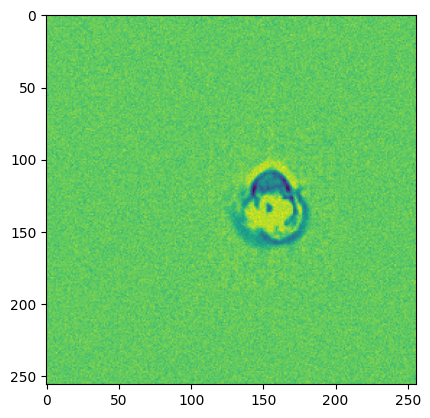

In [37]:
i = 40
plt.imshow(train_dataset[i][0][0,:,:])
print(train_dataset[i][1])

In [38]:
validation_transforms =  transforms.Compose([ 
        MinMaxScaler(           min_in =  statistics["p05"] , 
                                max_in =  statistics["p95"] , 
                                min_out =  0. , 
                                max_out =  1.),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        AddGaussianNoise(mean=0., std=0.01),
])

test_transforms =  transforms.Compose([ 
        MinMaxScaler(           min_in =  statistics["p05"] , 
                                max_in =  statistics["p95"] , 
                                min_out =  0. , 
                                max_out =  1.),
])

validation_dataset_resnet_18 = DatasetGenerator(metadata.loc[validation_index.tolist(),:],
                                 reshape_size=reshape_size, 
                                label_map=label_map,
                                transform=validation_transforms, 
                                selected_channels=selected_channels)

test_dataset_resnet_18 = DatasetGenerator(metadata.loc[test_index.tolist(),:],
                                 reshape_size=reshape_size, 
                                label_map=label_map,
                                transform=test_transforms, 
                                selected_channels=selected_channels)

In [39]:


#resnet18_modified.load_state_dict(torch.load('supervised_learning_synapse_model.pth')) 

#lr_scheduler = LRScheduler(policy='StepLR', step_size=5, gamma=0.6)
lr_scheduler = LRScheduler(policy='ReduceLROnPlateau', factor=0.1, patience=10)
#checkpoint = Checkpoint(f_params='resnet_18_imagenet_pretraiend_supervised_learning.pth', monitor='valid_acc_best')


epoch_scoring = EpochScoring("f1_macro", 
                             name =  "valid_f1_macro", 
                             on_train = False,
                             lower_is_better = False)

early_stopping = EarlyStopping(monitor='valid_f1_macro', 
                               patience=100, 
                               threshold=0.0001, 
                               threshold_mode='rel', 
                               lower_is_better=False)

model = NeuralNetClassifier(    
    resnet18_modified, 
    criterion=nn.CrossEntropyLoss,
    lr=0.01,
    batch_size=128,
    max_epochs=1000,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    iterator_train__num_workers=4,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    callbacks=[lr_scheduler,epoch_scoring, early_stopping],
    train_split=predefined_split(validation_dataset_resnet_18),
    device="cuda",
    warm_start=True)

In [40]:
model = model.fit(train_dataset, y = None)

OutOfMemoryError: CUDA out of memory. Tried to allocate 768.00 MiB. GPU 0 has a total capacity of 14.57 GiB of which 654.75 MiB is free. Process 1875067 has 192.00 MiB memory in use. Process 1932939 has 142.00 MiB memory in use. Including non-PyTorch memory, this process has 13.60 GiB memory in use. Of the allocated memory 13.10 GiB is allocated by PyTorch, and 387.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
## START from here

              precision    recall  f1-score   support

           0       0.97      0.98      0.97        89
           1       0.88      0.88      0.88        94
           2       0.82      0.83      0.82        70
           3       0.83      0.92      0.87        88
           4       0.87      0.73      0.79        74
           5       0.67      0.70      0.68        69
           6       0.74      0.78      0.76        94
           7       0.91      0.88      0.89        82
           8       0.96      0.90      0.93        71

    accuracy                           0.85       731
   macro avg       0.85      0.84      0.85       731
weighted avg       0.85      0.85      0.85       731

------------------------------------------------------------
matthews correlation coeff: 0.8290
Cohen Kappa score: 0.8288
Accuracy: 0.8482 & balanced Accuracy: 0.8434
macro F1 score: 0.8451 & micro F1 score: 0.8482
macro Precision score: 0.8491 & micro Precision score: 0.8482
macro Recall score

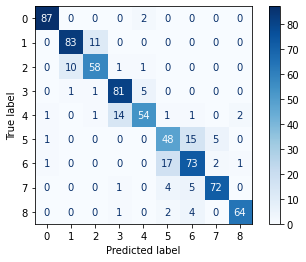

------------------------------------------------------------


In [ ]:
preds = model.predict(validation_dataset_resnet_18)

classification_complete_report([label_map[t] for t in validation_dataset_resnet_18.metadata.label], 
                               preds  )

In [ ]:
set_of_interesting_classes

['B_cell',
 'T_cell',
 'T_cell_with_signaling',
 'T_cell_with_B_cell_fragments',
 'B_T_cell_in_one_layer',
 'Synapses_without_signaling',
 'Synapses_with_signaling',
 'No_cell_cell_interaction',
 'Multiplets']

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       190
           1       0.91      0.89      0.90       200
           2       0.86      0.84      0.85       148
           3       0.90      0.92      0.91       189
           4       0.85      0.91      0.88       161
           5       0.61      0.73      0.67       147
           6       0.78      0.77      0.77       196
           7       0.94      0.91      0.92       182
           8       0.97      0.77      0.86       154

    accuracy                           0.86      1567
   macro avg       0.86      0.86      0.86      1567
weighted avg       0.87      0.86      0.86      1567

------------------------------------------------------------
matthews correlation coeff: 0.8451
Cohen Kappa score: 0.8447
Accuracy: 0.8622 & balanced Accuracy: 0.8577
macro F1 score: 0.8590 & micro F1 score: 0.8622
macro Precision score: 0.8646 & micro Precision score: 0.8622
macro Recall score

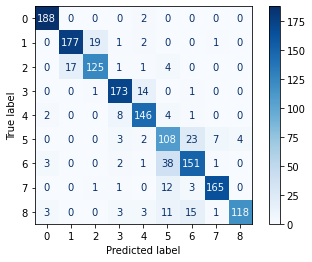

------------------------------------------------------------


In [ ]:
preds = model.predict(test_dataset_resnet_18)
#preds =  [inv_map[int(t)] for t in preds]

classification_complete_report([label_map[t] for t in test_dataset_resnet_18.metadata.label],  preds   )